![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - PyTorch</center>
### <center> CIFAR-10 Example </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_PyTorch/MainPyTorchCIFAR.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo

In [4]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt

#-- torch:
import torch
import torch.nn            as nn
# import torch.nn.functional as F
import torch.optim         as optim
import torchinfo

torch.backends.cudnn.benchmark = True

### Download CIFAR-10 dataset:

In [5]:
import torchvision
import torchvision.transforms as transforms

# DATA_PATH = '../../../FixelCourses/data/'
DATA_PATH = '../../data/'
oTrainSet = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes

oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

#### Plot some examples:

In [6]:
oTrainSet.data.shape, oTrainSet[0][0].shape

((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [7]:
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

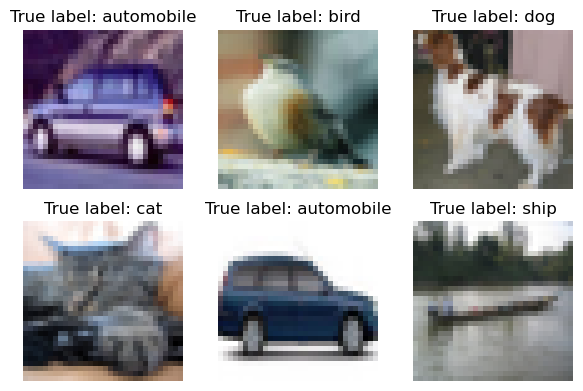

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(6, 4))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow(mX.permute(1,2,0))
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show        ()

#### Compute mean pixel and its variance:

In [9]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Add normalization to the datasets (using `transform`):

In [10]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd),
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [11]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

### Define the model (architecture):

In [12]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        nn.Flatten (),
        
        nn.Linear(3*32*32, 500), nn.ReLU(),
        nn.Linear(500,     250), nn.ReLU(),
        nn.Linear(250,     10 ),
    )
    return oModel

torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 3, 32, 32]          --
├─Flatten: 1-2                           [128, 3072]               --
├─Linear: 1-3                            [128, 500]                1,536,500
├─ReLU: 1-4                              [128, 500]                --
├─Linear: 1-5                            [128, 250]                125,250
├─ReLU: 1-6                              [128, 250]                --
├─Linear: 1-7                            [128, 10]                 2,510
Total params: 1,664,260
Trainable params: 1,664,260
Non-trainable params: 0
Total mult-adds (M): 213.03
Input size (MB): 1.57
Forward/backward pass size (MB): 0.78
Params size (MB): 6.66
Estimated Total Size (MB): 9.01

#### A simple test:

In [13]:
oModel  = GetModel()
mX      = torch.randn(128, 3, 32, 32)
mLogits = oModel(mX)
mX.shape, mLogits.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128, 10]))

#### Accuracy function
A `torch.tensor` stores the computational graph.  
Use `torch.Tensor.item()` to get a Python number from a tensor containing a single value.

In [14]:
x = torch.tensor(3.)
x.item()

3.0

In [15]:
#-- Classification accuracy:
def Accuracy(mLogits, vY):
    #-- mLogits.shape = (128, 10)
    #-- vY     .shape = (128,)
    mLogits  = mLogits.detach() #-- remove from the computional graph
    vHatY    = mLogits.argmax(dim=1)
    accuracy = (vHatY == vY).float().mean()
    return accuracy.item()
    
#-- Test the accuracy function:
Accuracy(mLogits, vY)

0.1171875

### PyTorch `Epoch`:

In [16]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE) #-- mX.shape = (128, 3, 32, 32)
        vY = vY.to(DEVICE) #-- vY.shape = (128,)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)     #-- forward
            loss = Loss  (mZ, vY) #-- Softmax + CE
    
            #-- Backward:
            oOptim.zero_grad() #-- set gradients to zeros
            loss  .backward () #-- backward
            oOptim.step     () #-- update parameters
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss  (mZ, vY)

        with torch.no_grad():
            Nb           = mX.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mZ, vY)
            
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric

In [17]:
import time

def TrainClassficationModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainDL, Loss, Accuracy, oOptim, bTrain=True ) #-- train
        valLoss,   valAcc   = Epoch(oModel, oValDL,   Loss, Accuracy,         bTrain=False) #-- validate
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}' ,  end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}' ,  end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                dCheckpoint = {'Model'     : oModel.state_dict(),
                               'Optimizer' : oOptim.state_dict()}
                torch.save(dCheckpoint, 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc

#### Check whether GPU is available:

In [18]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [19]:
nEpochs  = 20
Loss     = nn.CrossEntropyLoss()

oModel   = GetModel               ().to(DEVICE)
oOptim   = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

Epoch 000: | Train loss:  1.701 | Val loss:  1.537 | Train Accuracy:  0.402 | Val Accuracy:  0.465 | epoch time:  6.841 | <-- Checkpoint!
Epoch 001: | Train loss:  1.479 | Val loss:  1.448 | Train Accuracy:  0.484 | Val Accuracy:  0.494 | epoch time:  4.119 | <-- Checkpoint!
Epoch 002: | Train loss:  1.378 | Val loss:  1.399 | Train Accuracy:  0.521 | Val Accuracy:  0.509 | epoch time:  4.216 | <-- Checkpoint!
Epoch 003: | Train loss:  1.304 | Val loss:  1.365 | Train Accuracy:  0.547 | Val Accuracy:  0.521 | epoch time:  4.200 | <-- Checkpoint!
Epoch 004: | Train loss:  1.242 | Val loss:  1.352 | Train Accuracy:  0.569 | Val Accuracy:  0.520 | epoch time:  4.173 |
Epoch 005: | Train loss:  1.186 | Val loss:  1.336 | Train Accuracy:  0.591 | Val Accuracy:  0.528 | epoch time:  4.098 | <-- Checkpoint!
Epoch 006: | Train loss:  1.134 | Val loss:  1.321 | Train Accuracy:  0.610 | Val Accuracy:  0.534 | epoch time:  4.134 | <-- Checkpoint!
Epoch 007: | Train loss:  1.088 | Val loss:  1.319

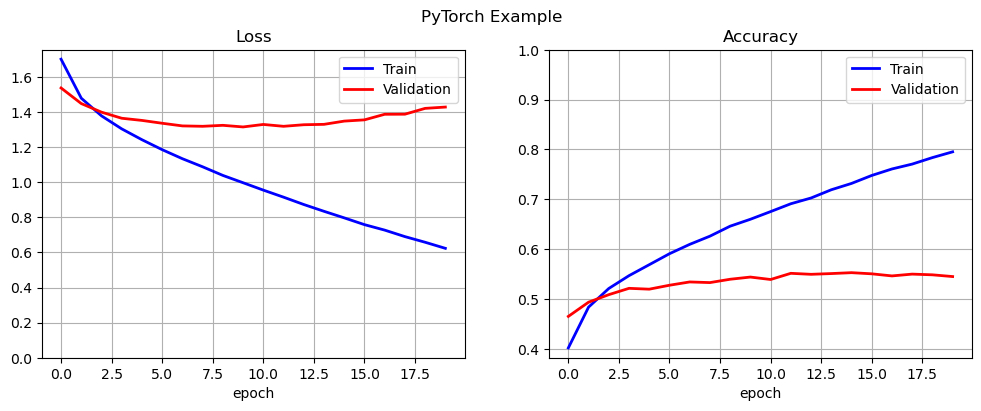

In [20]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
    plt.plot   (vValAcc,   'r', lw=2, label='Validation')
    plt.title  ('Accuracy')
    plt.xlabel ('epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('PyTorch Example')
plt.show    ()

### Exercise 1:
Improve the performance and get above 56% classification accuracy.
* Use dropout, `nn.Dropout(p)`<br>
Note that `p` is the probability of an element to be zeroed.

In [21]:
'''
Your code...
'''
???

Epoch 000: | Train loss:  1.726 | Val loss:  1.550 | Train Accuracy:  0.396 | Val Accuracy:  0.463 | epoch time:  4.171 | <-- Checkpoint!
Epoch 001: | Train loss:  1.521 | Val loss:  1.464 | Train Accuracy:  0.466 | Val Accuracy:  0.489 | epoch time:  4.063 | <-- Checkpoint!
Epoch 002: | Train loss:  1.430 | Val loss:  1.419 | Train Accuracy:  0.501 | Val Accuracy:  0.500 | epoch time:  4.078 | <-- Checkpoint!
Epoch 003: | Train loss:  1.361 | Val loss:  1.377 | Train Accuracy:  0.526 | Val Accuracy:  0.514 | epoch time:  4.039 | <-- Checkpoint!
Epoch 004: | Train loss:  1.308 | Val loss:  1.358 | Train Accuracy:  0.545 | Val Accuracy:  0.523 | epoch time:  4.146 | <-- Checkpoint!
Epoch 005: | Train loss:  1.261 | Val loss:  1.344 | Train Accuracy:  0.564 | Val Accuracy:  0.526 | epoch time:  4.055 | <-- Checkpoint!
Epoch 006: | Train loss:  1.219 | Val loss:  1.328 | Train Accuracy:  0.577 | Val Accuracy:  0.535 | epoch time:  4.094 | <-- Checkpoint!
Epoch 007: | Train loss:  1.179 | 

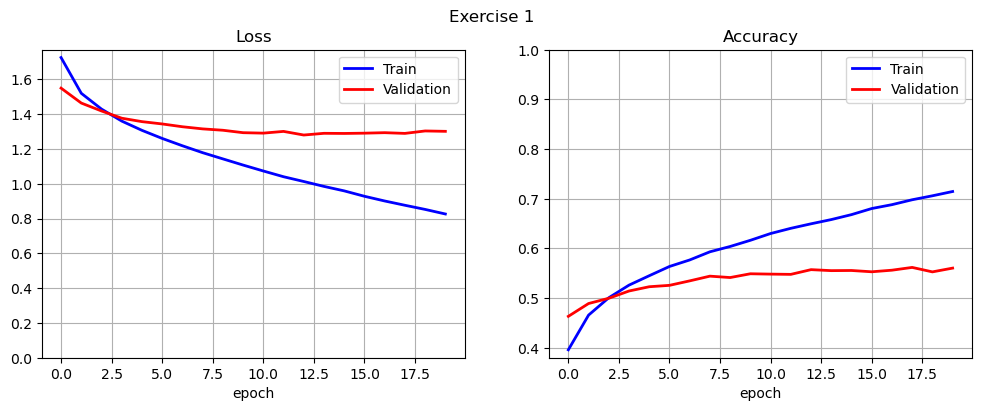

In [22]:
PlotHistory (lHistory)
plt.suptitle('Exercise 1')
plt.show    ()

### Exercise 2:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss: `nn.MSELoss()`
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.8$ (on the validation set) is quite good.

In [23]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= mX.mean(0)
mX     /= mX.std (0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [ ]:
from torch.utils.data import TensorDataset

nTrain              = 15000
nTest               = 5640
oDataset            = TensorDataset(torch.tensor(mX, dtype=torch.float32), torch.tensor(vY, dtype=torch.float32))
oTrainSet, oValSet  = torch.utils.data.random_split(oDataset, [nTrain, nTest])
len(oTrainSet), len(oValSet)

#### $R^2$ function
`tensor.detach()` creates a tensor that shares storage with `tensor` that does not require grad.

In [ ]:
from sklearn.metrics import r2_score

def R2Score(vHatY, vY):
    vY    = vY            .cpu().view(-1)
    vHatY = vHatY.detach().cpu().view(-1)
    return ???

In [ ]:
import time

def TrainRegressionModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainR2   = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValR2     = np.full(nEpochs, np.nan)
    bestR2     = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        trainLoss, trainR2 = Epoch(oModel, oTrainData, ???, ???, oOptim, bTrain=True ) #-- train
        valLoss,   valR2   = Epoch(oModel, oValData,   ???, ???,         bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '          f'{epoch     :03d}:',   end='')
        print(' | Train loss: ' f'{trainLoss :6.3f}' ,  end='')
        print(' | Val loss: '   f'{valLoss   :6.3f}' ,  end='')
        print(' | Train R2: '   f'{trainR2  :+6.3f}',   end='')
        print(' | Val R2: '     f'{valR2    :+6.3f}',   end='')
        print(' | epoch time: ' f'{epochTime :3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainR2  [epoch] = trainR2
        vValLoss  [epoch] = valLoss
        vValR2    [epoch] = valR2

        #-- Save best model (early stopping):
        if ??? < ???:
            ??? = ???
            try:
                dCheckpoint = {'Model'     : oModel.state_dict(),
                               'Optimizer' : oOptim.state_dict()}
                torch.save(dCheckpoint, 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])

    return vTrainLoss, vTrainR2, vValLoss, vValR2

In [ ]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [ ]:
import torch.nn            as nn
import torch.optim         as optim
import torchinfo

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),  #-- does nothing
        ???
        
        nn.Flatten(start_dim=0)
    )
   
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

In [12]:
Loss    = ???
nEpochs = ???

oModel  = GetModel().to(DEVICE)
oOptim  = ???

lHistory = TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim)

Epoch 000: | Train loss:  1.685 | Val loss:  0.686 | Train R²: -0.287 | Val R²: +0.489 | epoch time: 1.457 | <-- Checkpoint!
Epoch 001: | Train loss:  2.760 | Val loss:  0.523 | Train R²: -0.953 | Val R²: +0.610 | epoch time: 0.360 | <-- Checkpoint!
Epoch 002: | Train loss:  3.510 | Val loss:  2.344 | Train R²: -2.907 | Val R²: -0.747 | epoch time: 0.341 |
Epoch 003: | Train loss: 13.824 | Val loss:  0.458 | Train R²: -10.759 | Val R²: +0.660 | epoch time: 0.337 | <-- Checkpoint!
Epoch 004: | Train loss:  1.091 | Val loss:  5.326 | Train R²: +0.226 | Val R²: -2.973 | epoch time: 0.336 |
Epoch 005: | Train loss:  4.677 | Val loss:  0.715 | Train R²: -2.432 | Val R²: +0.455 | epoch time: 0.351 |
Epoch 006: | Train loss: 10.189 | Val loss:  0.443 | Train R²: -7.420 | Val R²: +0.672 | epoch time: 0.337 | <-- Checkpoint!
Epoch 007: | Train loss:  1.468 | Val loss:  0.373 | Train R²: -0.250 | Val R²: +0.724 | epoch time: 0.351 | <-- Checkpoint!
Epoch 008: | Train loss:  0.476 | Val loss:  0.

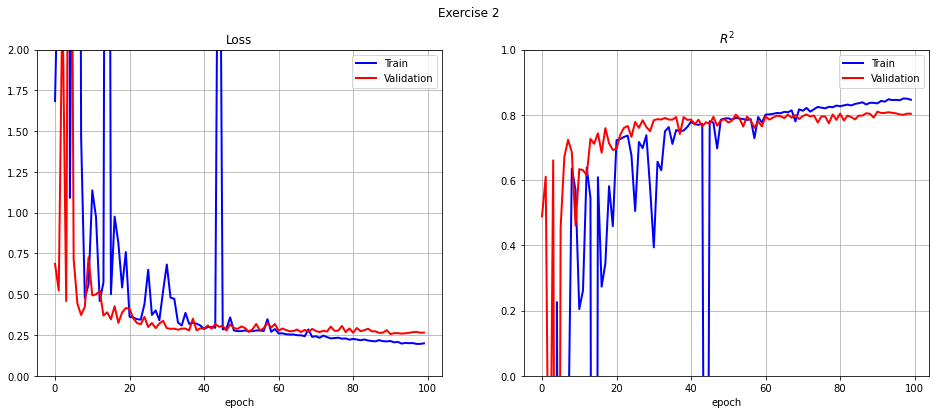

In [13]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainR2, 'b', lw=2, label='Train'     )
    plt.plot   (vValR2,   'r', lw=2, label='Validation')
    plt.title  ('$R^2$')
    plt.xlabel ('epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('PyTorch Example')
plt.show    ()

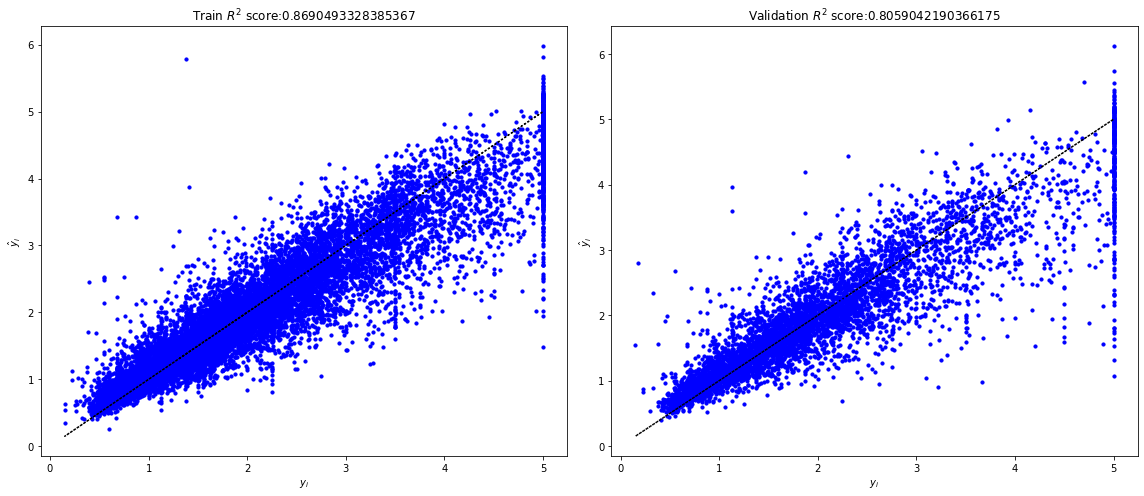

In [14]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,   s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.show        ()

In [ ]:
# def GetModel2():
#     oModel = nn.Sequential(
#         nn.Identity(), #-- does nothing
#         nn.Flatten (),
        
#         nn.Linear(3*32*32, 500), nn.Dropout(0.1), nn.ReLU(),
#         nn.Linear(500,     250), nn.Dropout(0.1), nn.ReLU(),
#         nn.Linear(250,      10)
#     )
#     return oModel

# nEpochs = 20
# Loss    = nn.CrossEntropyLoss()

# oModel   = GetModel2              ().to(DEVICE)
# oOptim   = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
# lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);